In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import os
import cv2
import albumentations as A
from tqdm import tqdm

DATA_DIR = '/content/drive/MyDrive/Logo-2k+-subclass_preprocessed/train_and_test'


In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.6/793.6 kB 15.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [7]:

def augment_image(image):
    # Define the augmentation pipeline
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Blur(p=0.2),
        A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=20, shift_limit=0.2, p=0.5)
    ])
    augmented = transform(image=image)
    return augmented['image']

def apply_filters(image):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # High pass filtering
    kernel = -1 * np.ones((3, 3), dtype=np.float32)
    kernel[1, 1] = 8
    high_pass = cv2.filter2D(gray_image, -1, kernel)

    return high_pass

def process_train_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, _, files in os.walk(input_folder):
        subfolder = os.path.relpath(root, input_folder)
        output_subfolder = os.path.join(output_folder, subfolder)
        if not os.path.exists(output_subfolder):
            os.makedirs(output_subfolder)

        image_files = [f for f in files if f.endswith((".jpg", ".png"))]
        num_images = len(image_files)

        if num_images == 0:
            continue

        # Limit the number of images per subfolder to 600
        total_images_needed = 300
        num_augmented_images_per_original = total_images_needed // num_images
        extra_images_needed = total_images_needed - (num_augmented_images_per_original * num_images)

        image_counter = 0

        for filename in tqdm(image_files, desc=f"Processing {subfolder}"):
            img_path = os.path.join(root, filename)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Failed to load image: {img_path}")
                continue

            for i in range(num_augmented_images_per_original):
                if image_counter >= total_images_needed:
                    break
                augmented_img = augment_image(img)
                processed_img = apply_filters(augmented_img)
                output_path = os.path.join(output_subfolder, f"{os.path.splitext(filename)[0]}_aug_{i}.jpg")
                cv2.imwrite(output_path, processed_img)
                image_counter += 1

            if image_counter >= total_images_needed:
                break

            # Generate extra images if needed
            for i in range(extra_images_needed):
                if image_counter >= total_images_needed:
                    break
                augmented_img = augment_image(img)
                processed_img = apply_filters(augmented_img)
                output_path = os.path.join(output_subfolder, f"{os.path.splitext(filename)[0]}_extra_aug_{i}.jpg")
                cv2.imwrite(output_path, processed_img)
                image_counter += 1

def copy_test_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, _, files in os.walk(input_folder):
        subfolder = os.path.relpath(root, input_folder)
        output_subfolder = os.path.join(output_folder, subfolder)
        if not os.path.exists(output_subfolder):
            os.makedirs(output_subfolder)

        image_files = [f for f in files if f.endswith((".jpg", ".png"))]

        for filename in tqdm(image_files, desc=f"Copying {subfolder}"):
            img_path = os.path.join(root, filename)
            img = cv2.imread(img_path)
            output_path = os.path.join(output_subfolder, filename)
            cv2.imwrite(output_path, img)


input_train_folder = os.path.normpath(os.path.join(DATA_DIR, 'train'))
input_test_folder = os.path.normpath(os.path.join(DATA_DIR, 'test'))
output_folder = os.path.normpath(os.path.join(DATA_DIR, 'processed'))

output_train_folder = os.path.join(output_folder, "train")
output_test_folder = os.path.join(output_folder, "test")

# Process and augment train data
process_train_images(input_train_folder, output_train_folder)

# Copy test data without processing
copy_test_images(input_test_folder, output_test_folder)

print("Processing complete.")


Processing Kirkland Signature:  11%|█         | 7/65 [00:07<01:05,  1.12s/it]
Copying .: 0it [00:00, ?it/s]
Copying Albertsons: 100%|██████████| 33/33 [00:19<00:00,  1.66it/s]

Processing complete.


In [10]:
# Apply grayscaling and high-pass filtering on the test images
def process_test_images(input_folder):
    for root, _, files in os.walk(input_folder):
        subfolder = os.path.relpath(root, input_folder)

        image_files = [f for f in files if f.endswith((".jpg", ".png"))]

        for filename in tqdm(image_files, desc=f"Processing {subfolder}"):
            img_path = os.path.join(root, filename)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Failed to load image: {img_path}")
                continue

            processed_img = apply_filters(img)
            cv2.imwrite(img_path, processed_img)

# Define your input folder
TEST_DATA_DIR = "/content/drive/MyDrive/Logo-2k+-subclass_preprocessed/train_and_test/processed/test"

# Apply filters to test data
process_test_images(TEST_DATA_DIR)

Processing .: 0it [00:00, ?it/s]
Processing Albertsons: 100%|██████████| 33/33 [00:00<00:00, 65.52it/s]


In [11]:
import os

from ultralytics import YOLO
# Load a model
model = YOLO("/content/drive/MyDrive/yolov9c-cls.yaml")  # build a new model for logo classification using custom YAML



YOLOv9c-cls summary: 300 layers, 9745680 parameters, 9745680 gradients, 43.4 GFLOPs


In [12]:
# Use the model
results = model.train(data=os.path.join(DATA_DIR, 'processed'), epochs=50, imgsz=256)  # train the model


Ultralytics YOLOv8.2.45 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=/content/drive/MyDrive/yolov9c-cls.yaml, data=/content/drive/MyDrive/Logo-2k+-subclass_preprocessed/train_and_test/processed, epochs=50, time=None, patience=100, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_

train: Scanning /content/drive/MyDrive/Logo-2k+-subclass_preprocessed/train_and_test/processed/train... 14400 images, 0 corrupt: 100%|██████████| 14400/14400 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/Logo-2k+-subclass_preprocessed/train_and_test/processed/test... 1095 images, 0 corrupt: 100%|██████████| 1095/1095 [00:06<00:00, 172.03it/s]


val: New cache created: /content/drive/MyDrive/Logo-2k+-subclass_preprocessed/train_and_test/processed/test.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 75 weight(decay=0.0), 76 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/classify/train2
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:10<00:00,  3.34it/s]

                   all     0.0174      0.122



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.89it/s]

                   all     0.0256      0.148



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.72it/s]

                   all      0.063      0.297



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:10<00:00,  3.35it/s]

                   all      0.132      0.382



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:08<00:00,  4.14it/s]

                   all      0.201      0.426



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.67it/s]

                   all      0.202      0.463



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:11<00:00,  2.92it/s]

                   all      0.205      0.437



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.62it/s]

                   all      0.236      0.495



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.75it/s]

                   all      0.268      0.528



      Epoch    GPU_mem       loss  Instances       Size


      10/50       1.6G      1.841         16        256: 100%|██████████| 900/900 [04:00<00:00,  3.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.87it/s]

                   all      0.285      0.525



      Epoch    GPU_mem       loss  Instances       Size


      11/50       1.6G      1.606         16        256: 100%|██████████| 900/900 [03:53<00:00,  3.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.82it/s]

                   all        0.3      0.535



      Epoch    GPU_mem       loss  Instances       Size


      12/50      1.59G       1.39         16        256: 100%|██████████| 900/900 [03:52<00:00,  3.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:10<00:00,  3.25it/s]

                   all      0.319      0.532



      Epoch    GPU_mem       loss  Instances       Size


      13/50      1.59G      1.218         16        256: 100%|██████████| 900/900 [04:00<00:00,  3.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.55it/s]

                   all        0.3      0.545



      Epoch    GPU_mem       loss  Instances       Size


      14/50      1.61G      1.069         16        256: 100%|██████████| 900/900 [03:56<00:00,  3.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:08<00:00,  3.98it/s]

                   all      0.342       0.54



      Epoch    GPU_mem       loss  Instances       Size


      15/50      1.59G     0.9615         16        256: 100%|██████████| 900/900 [03:56<00:00,  3.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:08<00:00,  4.37it/s]

                   all      0.341      0.553



      Epoch    GPU_mem       loss  Instances       Size


      16/50      1.59G     0.8384         16        256: 100%|██████████| 900/900 [03:54<00:00,  3.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:11<00:00,  3.17it/s]

                   all       0.36      0.559



      Epoch    GPU_mem       loss  Instances       Size


      17/50      1.59G     0.7643         16        256: 100%|██████████| 900/900 [03:56<00:00,  3.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.85it/s]

                   all       0.35      0.549



      Epoch    GPU_mem       loss  Instances       Size


      18/50      1.59G     0.6952         16        256: 100%|██████████| 900/900 [03:57<00:00,  3.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.55it/s]

                   all       0.34      0.551



      Epoch    GPU_mem       loss  Instances       Size


      19/50      1.59G     0.6189         16        256: 100%|██████████| 900/900 [03:54<00:00,  3.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.64it/s]

                   all      0.351       0.57



      Epoch    GPU_mem       loss  Instances       Size


      20/50      1.59G      0.592         16        256: 100%|██████████| 900/900 [03:56<00:00,  3.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.51it/s]

                   all      0.365      0.559



      Epoch    GPU_mem       loss  Instances       Size


      21/50      1.59G     0.5463         16        256: 100%|██████████| 900/900 [03:52<00:00,  3.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:10<00:00,  3.36it/s]

                   all      0.351      0.577



      Epoch    GPU_mem       loss  Instances       Size


      22/50      1.59G     0.4896         16        256: 100%|██████████| 900/900 [03:52<00:00,  3.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.72it/s]

                   all      0.362      0.555



      Epoch    GPU_mem       loss  Instances       Size


      23/50      1.59G      0.458         16        256: 100%|██████████| 900/900 [03:57<00:00,  3.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.45it/s]

                   all       0.37      0.574



      Epoch    GPU_mem       loss  Instances       Size


      24/50      1.59G     0.4261         16        256: 100%|██████████| 900/900 [04:01<00:00,  3.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.54it/s]

                   all      0.357      0.552



      Epoch    GPU_mem       loss  Instances       Size


      25/50      1.59G     0.3813         16        256: 100%|██████████| 900/900 [03:56<00:00,  3.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.72it/s]

                   all      0.377      0.574



      Epoch    GPU_mem       loss  Instances       Size


      26/50      1.59G     0.3709         16        256: 100%|██████████| 900/900 [03:52<00:00,  3.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.53it/s]

                   all      0.372      0.561



      Epoch    GPU_mem       loss  Instances       Size


      27/50      1.59G     0.3445         16        256: 100%|██████████| 900/900 [03:59<00:00,  3.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:08<00:00,  4.25it/s]

                   all      0.377      0.569



      Epoch    GPU_mem       loss  Instances       Size


      28/50      1.59G     0.3252         16        256: 100%|██████████| 900/900 [03:58<00:00,  3.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.79it/s]

                   all      0.395      0.581



      Epoch    GPU_mem       loss  Instances       Size


      29/50      1.59G     0.3031         16        256: 100%|██████████| 900/900 [03:57<00:00,  3.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.41it/s]

                   all      0.385      0.576



      Epoch    GPU_mem       loss  Instances       Size


      30/50      1.59G     0.2768         16        256: 100%|██████████| 900/900 [04:00<00:00,  3.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.42it/s]

                   all      0.395      0.583



      Epoch    GPU_mem       loss  Instances       Size


      31/50      1.59G     0.2717         16        256: 100%|██████████| 900/900 [04:02<00:00,  3.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.85it/s]

                   all      0.379      0.583



      Epoch    GPU_mem       loss  Instances       Size


      32/50      1.59G     0.2526         16        256: 100%|██████████| 900/900 [03:57<00:00,  3.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:11<00:00,  3.17it/s]

                   all       0.38      0.586



      Epoch    GPU_mem       loss  Instances       Size


      33/50      1.59G     0.2338         16        256: 100%|██████████| 900/900 [03:56<00:00,  3.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:08<00:00,  3.89it/s]

                   all      0.388      0.572



      Epoch    GPU_mem       loss  Instances       Size


      34/50      1.59G     0.2176         16        256: 100%|██████████| 900/900 [04:01<00:00,  3.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.49it/s]

                   all      0.386      0.575



      Epoch    GPU_mem       loss  Instances       Size


      35/50      1.59G     0.2072         16        256: 100%|██████████| 900/900 [04:04<00:00,  3.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.65it/s]

                   all      0.389      0.571



      Epoch    GPU_mem       loss  Instances       Size


      36/50      1.59G     0.1875         16        256: 100%|██████████| 900/900 [03:55<00:00,  3.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.63it/s]

                   all      0.393      0.564



      Epoch    GPU_mem       loss  Instances       Size


      37/50      1.59G     0.1745         16        256: 100%|██████████| 900/900 [03:56<00:00,  3.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.86it/s]

                   all      0.382      0.567



      Epoch    GPU_mem       loss  Instances       Size


      38/50      1.59G     0.1657         16        256: 100%|██████████| 900/900 [03:59<00:00,  3.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.87it/s]

                   all      0.388      0.584



      Epoch    GPU_mem       loss  Instances       Size


      39/50      1.59G       0.16         16        256: 100%|██████████| 900/900 [03:56<00:00,  3.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:08<00:00,  4.33it/s]

                   all       0.39      0.578



      Epoch    GPU_mem       loss  Instances       Size


      40/50      1.59G     0.1501         16        256: 100%|██████████| 900/900 [03:58<00:00,  3.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.82it/s]

                   all      0.405      0.573



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem       loss  Instances       Size


      41/50      1.59G     0.1536         16        256: 100%|██████████| 900/900 [03:54<00:00,  3.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.72it/s]

                   all      0.406      0.581



      Epoch    GPU_mem       loss  Instances       Size


      42/50      1.59G     0.1397         16        256: 100%|██████████| 900/900 [03:56<00:00,  3.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.65it/s]

                   all      0.395       0.58



      Epoch    GPU_mem       loss  Instances       Size


      43/50      1.59G     0.1302         16        256: 100%|██████████| 900/900 [04:03<00:00,  3.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.83it/s]

                   all      0.401      0.576



      Epoch    GPU_mem       loss  Instances       Size


      44/50      1.59G     0.1175         16        256: 100%|██████████| 900/900 [03:58<00:00,  3.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.90it/s]

                   all      0.402      0.586



      Epoch    GPU_mem       loss  Instances       Size


      45/50      1.59G      0.117         16        256: 100%|██████████| 900/900 [03:58<00:00,  3.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.57it/s]

                   all      0.396      0.575



      Epoch    GPU_mem       loss  Instances       Size


      46/50      1.59G     0.1017         16        256: 100%|██████████| 900/900 [03:57<00:00,  3.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:08<00:00,  4.34it/s]

                   all      0.398      0.574



      Epoch    GPU_mem       loss  Instances       Size


      47/50      1.59G    0.09765         16        256: 100%|██████████| 900/900 [03:54<00:00,  3.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:08<00:00,  4.27it/s]

                   all        0.4      0.578



      Epoch    GPU_mem       loss  Instances       Size


      48/50      1.59G     0.1093         16        256: 100%|██████████| 900/900 [03:56<00:00,  3.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.49it/s]

                   all        0.4      0.583



      Epoch    GPU_mem       loss  Instances       Size


      49/50      1.59G    0.09387         16        256: 100%|██████████| 900/900 [03:56<00:00,  3.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.67it/s]

                   all      0.397      0.577



      Epoch    GPU_mem       loss  Instances       Size


      50/50      1.59G    0.08964         16        256: 100%|██████████| 900/900 [03:58<00:00,  3.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:10<00:00,  3.34it/s]

                   all      0.398      0.576



50 epochs completed in 3.460 hours.
Optimizer stripped from runs/classify/train2/weights/last.pt, 19.6MB
Optimizer stripped from runs/classify/train2/weights/best.pt, 19.6MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics YOLOv8.2.45 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c-cls summary (fused): 185 layers, 9615152 parameters, 0 gradients, 42.6 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /content/drive/MyDrive/Logo-2k+-subclass_preprocessed/train_and_test/processed/train... found 14400 images in 48 classes ✅ 
val: None...
test: /content/drive/MyDrive/Logo-2k+-subclass_preprocessed/train_and_test/processed/test... found 1095 images in 48 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.49it/s]


                   all      0.403      0.586
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2
Results saved to runs/classify/train2


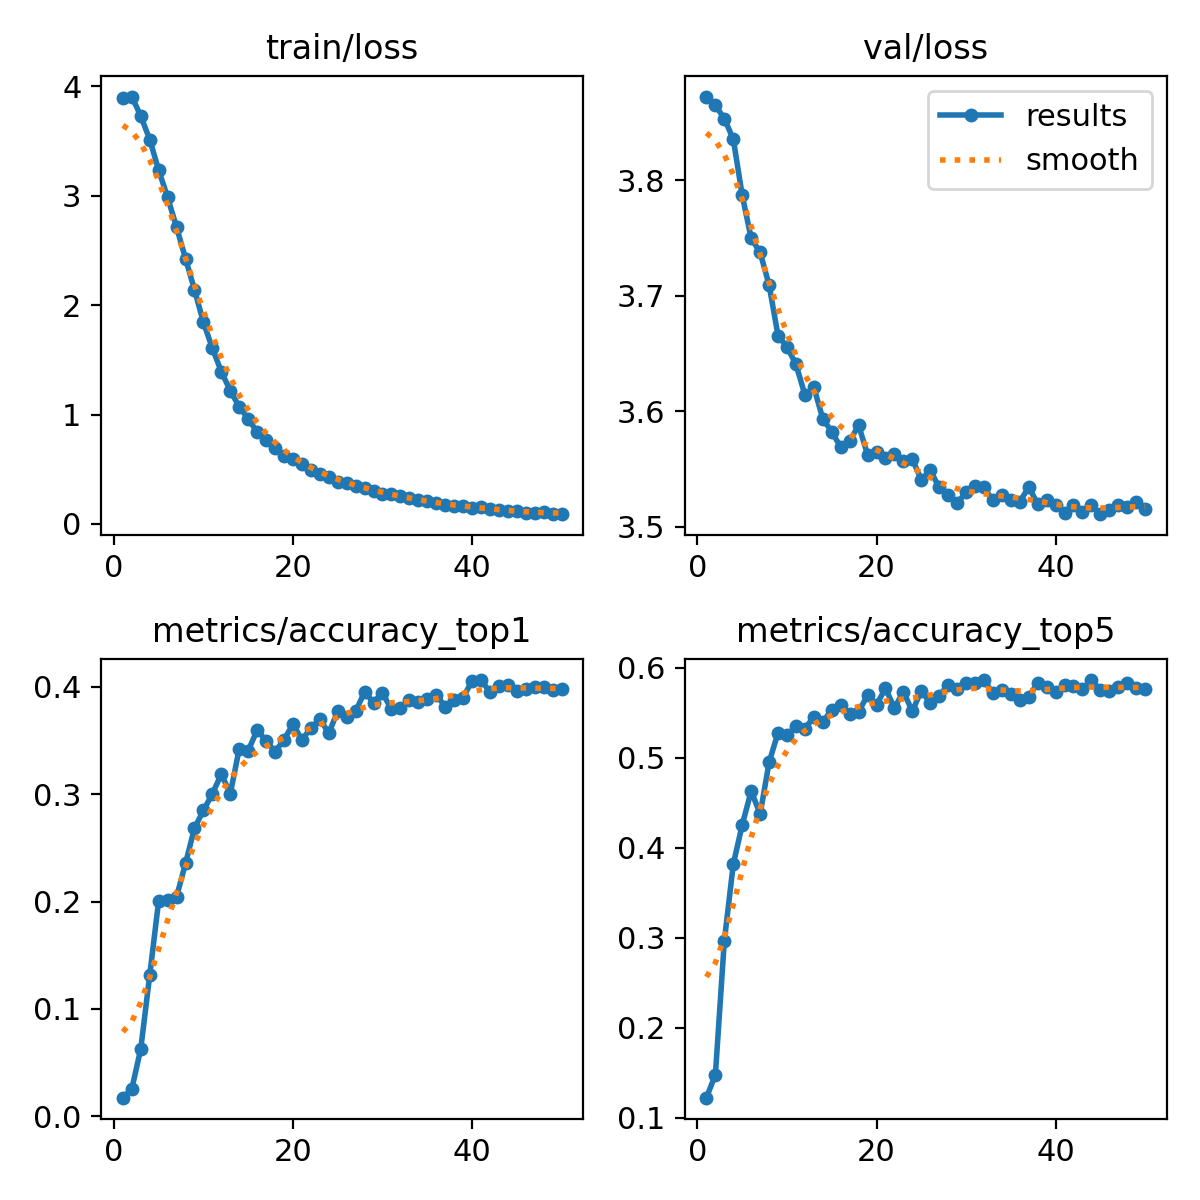

In [14]:
from IPython.display import Image
# Display the training results
Image('runs/classify/train2/results.png')

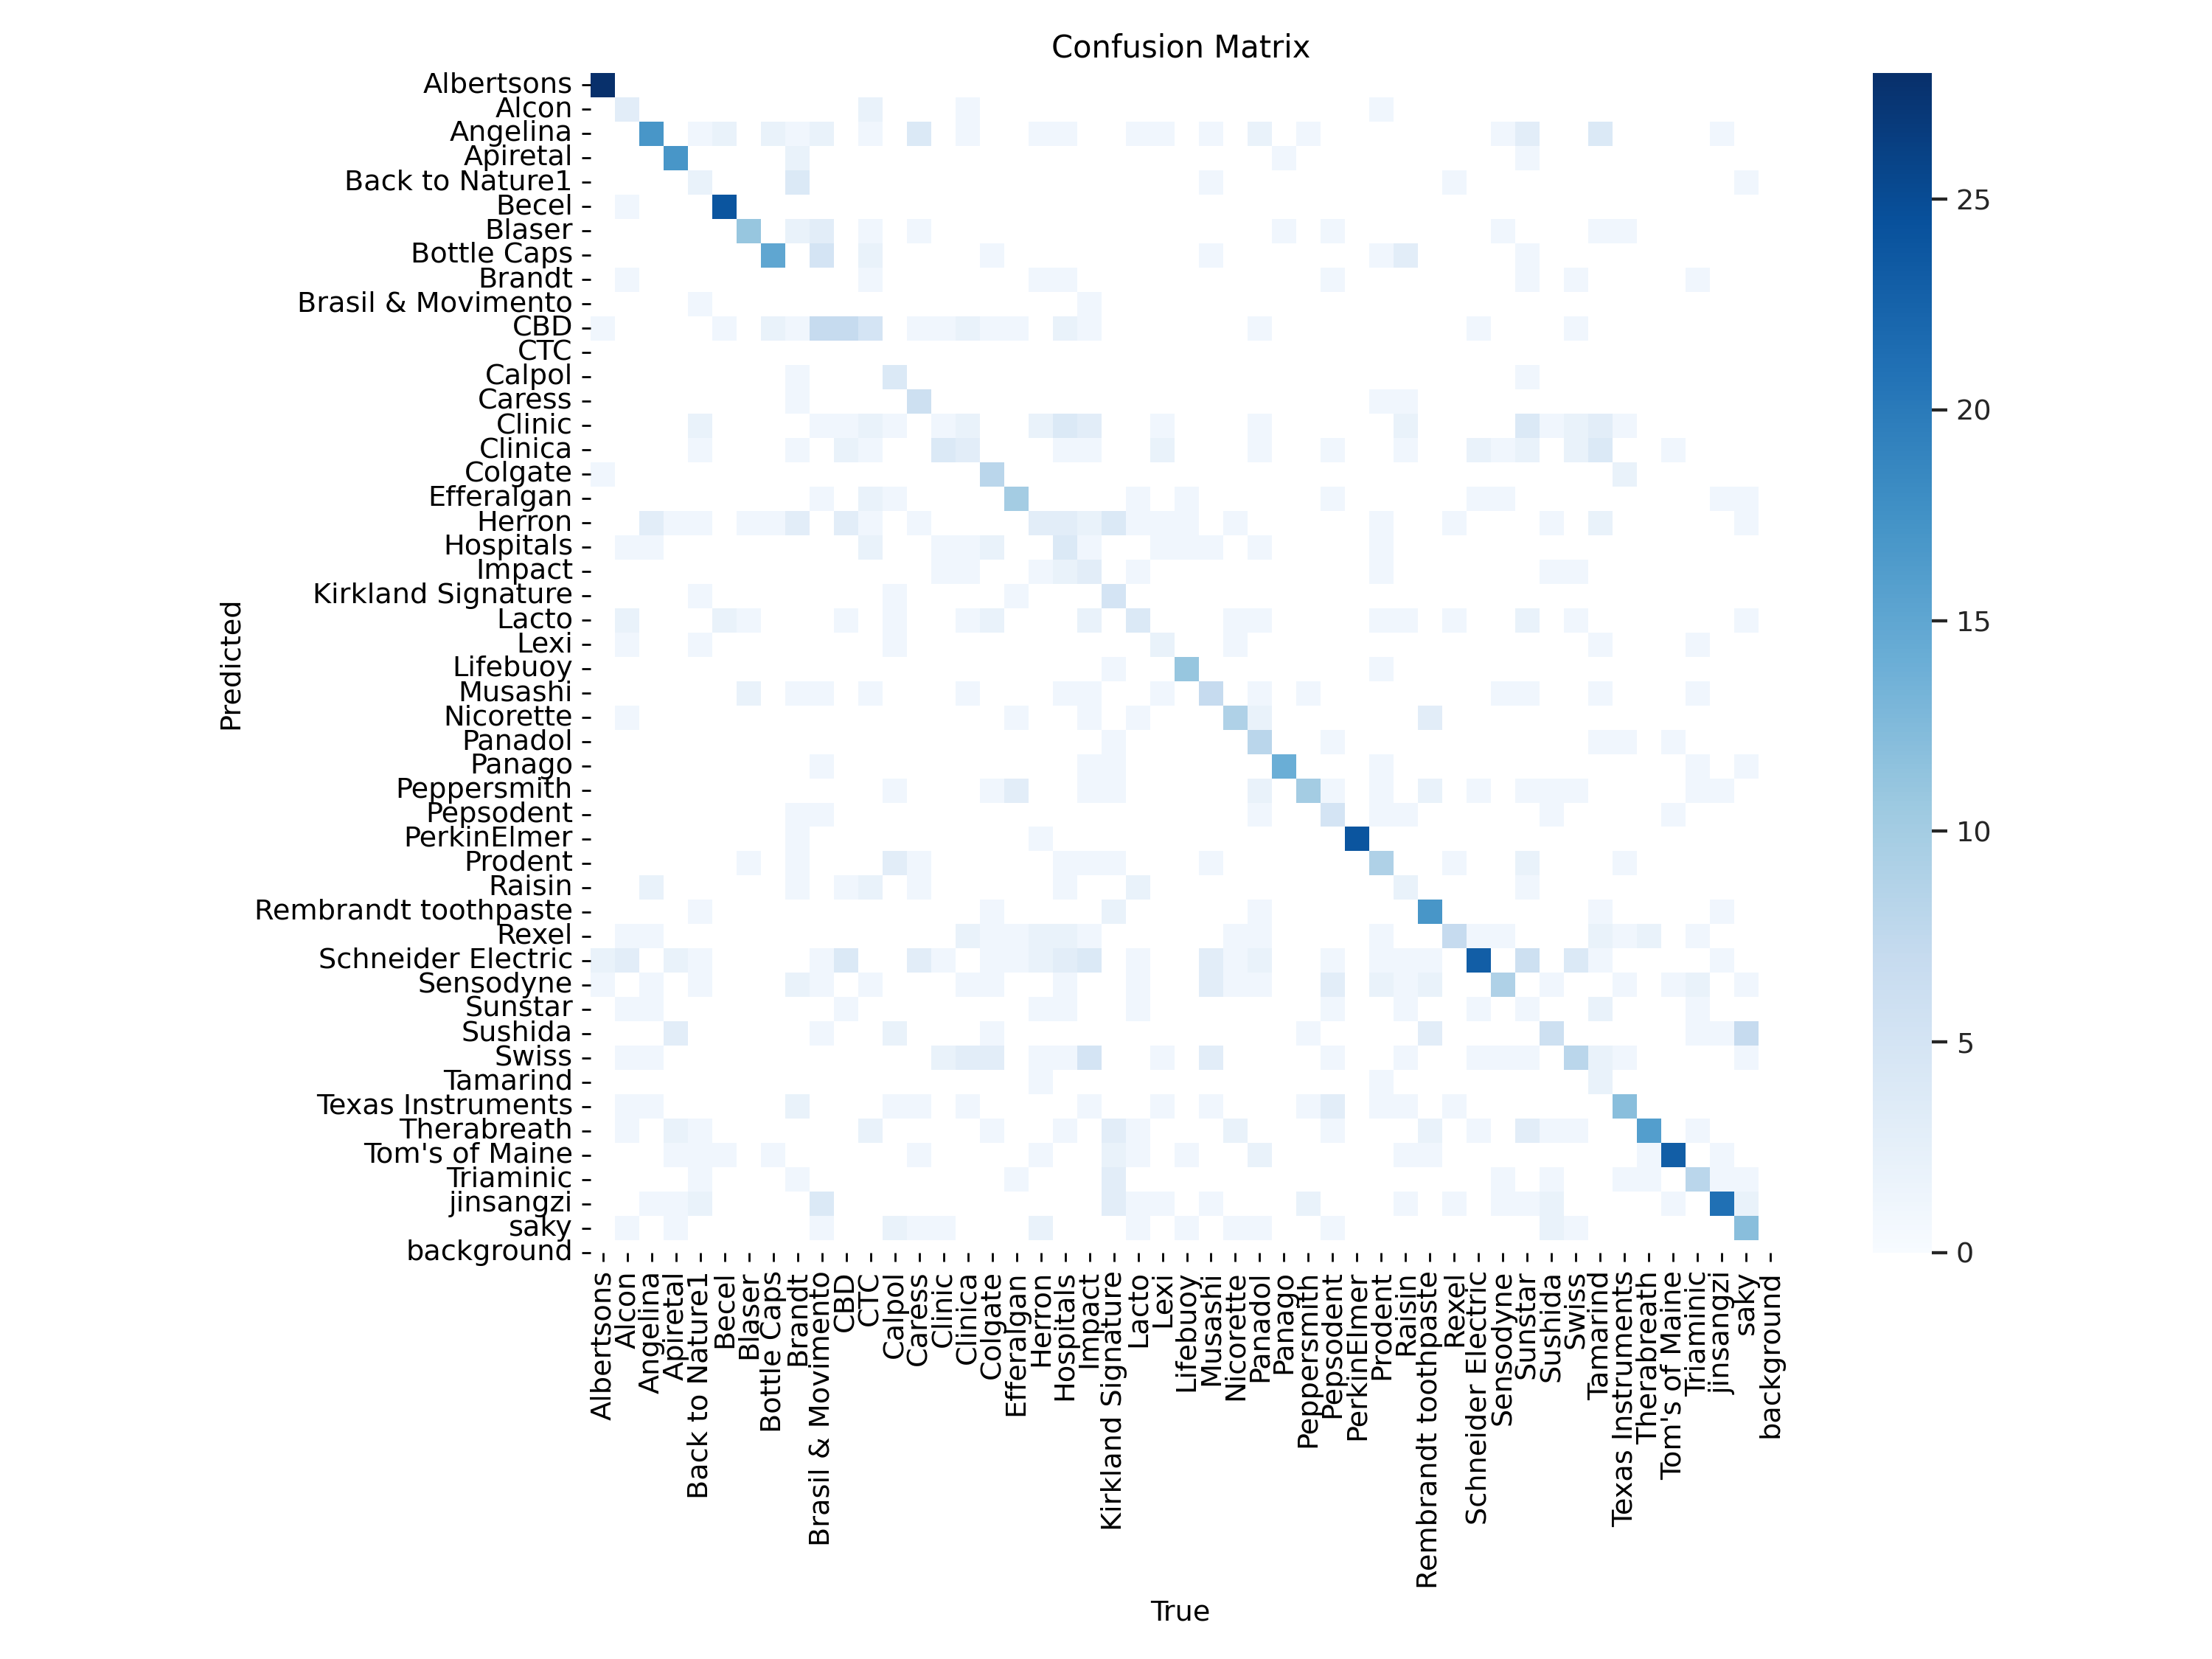

In [15]:
# Display the confusion matrix
Image('runs/classify/train2/confusion_matrix.png')

In [16]:
# Download the results folder from colab to your local machine
# Compress the folder
!zip -r /content/runs/classify/train2.zip /content/runs/classify/train2

# Download the compressed folder
from google.colab import files
files.download('/content/runs/classify/train2.zip')


  adding: content/runs/classify/train2/ (stored 0%)
  adding: content/runs/classify/train2/val_batch0_pred.jpg (deflated 9%)
  adding: content/runs/classify/train2/results.csv (deflated 86%)
  adding: content/runs/classify/train2/train_batch36002.jpg (deflated 12%)
  adding: content/runs/classify/train2/val_batch1_pred.jpg (deflated 8%)
  adding: content/runs/classify/train2/events.out.tfevents.1719589033.509a10bb6f4b.6379.1 (deflated 94%)
  adding: content/runs/classify/train2/train_batch36000.jpg (deflated 12%)
  adding: content/runs/classify/train2/train_batch0.jpg (deflated 12%)
  adding: content/runs/classify/train2/args.yaml (deflated 52%)
  adding: content/runs/classify/train2/val_batch2_pred.jpg (deflated 10%)
  adding: content/runs/classify/train2/weights/ (stored 0%)
  adding: content/runs/classify/train2/weights/best.pt (deflated 9%)
  adding: content/runs/classify/train2/weights/last.pt (deflated 9%)
  adding: content/runs/classify/train2/results.png (deflated 8%)
  adding:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# Validation
best_model = YOLO('/content/runs/classify/train2/weights/best.pt')


# Testing the best Model
test_results = best_model.predict(source='/content/drive/MyDrive/Logo-2k+-subclass_preprocessed/train_and_test/processed/test/Albertsons/19.jpg', stream=False, conf=0.25, save=True)

class_names = test_results[0].names
class_probabilities_predict = test_results[0].probs # Probabilities associated with all the classes predicted by our model
predicted_class = class_names[np.argmax(class_probabilities_predict.data.cpu()).item()]

print(f"Predicted class for the test image from Albertsons logo: {predicted_class}")


image 1/1 /content/drive/MyDrive/Logo-2k+-subclass_preprocessed/train_and_test/processed/test/Albertsons/19.jpg: 256x256 Albertsons 1.00, Swiss 0.00, Clinica 0.00, Caress 0.00, Colgate 0.00, 13.8ms
Speed: 3.8ms preprocess, 13.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)
Results saved to runs/classify/predict4
Predicted class for the test image from Albertsons logo: Albertsons
